<a href="https://colab.research.google.com/github/Hey-El/TimeSeriesForecasting/blob/main/DrugReviewProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install transformers
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [12]:

df=pd.read_excel('/content/DrugReview.xlsx')
df.shape

(53766, 7)

In [13]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4


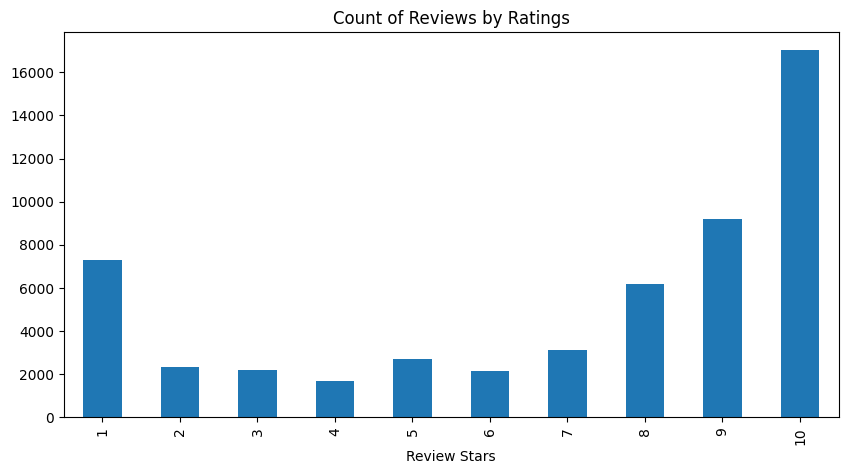

In [14]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Ratings',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [15]:
example = df['review'][50]
print(example)

"I&#039;ve had this birth control for a year now and at first things were going good, I only had a period once and never had one since but now I have super bad anxiety, I would constantly think I was pregnant, would waste my money on pregnancy test even though I am NOT pregnant and my depression was very bad and honestly , I really don&#039;t think it&#039;s worth it at all. I&#039;m getting it removed tomorrow and I most likely am going to have to be in therapy."


In [25]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['``', 'I', '&', '#', '039', ';', 've', 'had', 'this', 'birth']

In [28]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('``', '``'),
 ('I', 'PRP'),
 ('&', 'CC'),
 ('#', '#'),
 ('039', 'CD'),
 (';', ':'),
 ('ve', 'NN'),
 ('had', 'VBD'),
 ('this', 'DT'),
 ('birth', 'NN')]

In [35]:
#can divide tokens into chunks

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  ``/``
  I/PRP
  &/CC
  #/#
  039/CD
  ;/:
  ve/NN
  had/VBD
  this/DT
  birth/NN
  control/NN
  for/IN
  a/DT
  year/NN
  now/RB
  and/CC
  at/IN
  first/JJ
  things/NNS
  were/VBD
  going/VBG
  good/JJ
  ,/,
  I/PRP
  only/RB
  had/VBD
  a/DT
  period/NN
  once/RB
  and/CC
  never/RB
  had/VBD
  one/CD
  since/IN
  but/CC
  now/RB
  I/PRP
  have/VBP
  super/JJ
  bad/JJ
  anxiety/NN
  ,/,
  I/PRP
  would/MD
  constantly/RB
  think/VB
  I/PRP
  was/VBD
  pregnant/JJ
  ,/,
  would/MD
  waste/VB
  my/PRP$
  money/NN
  on/IN
  pregnancy/NN
  test/NN
  even/RB
  though/IN
  I/PRP
  am/VBP
  (ORGANIZATION NOT/NNP)
  pregnant/JJ
  and/CC
  my/PRP$
  depression/NN
  was/VBD
  very/RB
  bad/JJ
  and/CC
  honestly/RB
  ,/,
  I/PRP
  really/RB
  don/VB
  &/CC
  #/#
  039/CD
  ;/:
  t/NN
  think/VBP
  it/PRP
  &/CC
  #/#
  039/CD
  ;/:
  s/PRP
  worth/IN
  it/PRP
  at/IN
  all/DT
  ./.
  I/PRP
  &/CC
  #/#
  039/CD
  ;/:
  m/CD
  getting/VBG
  it/PRP
  removed/VBD
  tomorrow/NN
  and/CC
  I/P

In [39]:
#VADER Seniment Scoring

#This uses a "bag of words" approach:
#Stop words are removed
#each word is scored and combined to a total score.

sia = SentimentIntensityAnalyzer()
sia.polarity_scores('I am so happy!')
#compound score provided which is the overall sum of the scores for each categories assigned e.g negative etc

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [41]:
#using the tqdm library to display a progress bar while iterating through rows in a DataFrame and calculating sentiment scores using the sia.polarity_scores() function
# Initialize an empty dictionary to store results
res = {}

# Limit the loop to iterate through the first 1000 rows
for i, row in tqdm(df.head(1000).iterrows(), total=1000):
    review = row['review']
    myid = row['Unnamed:0']
    res[myid] = sia.polarity_scores(review)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: ignored